In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
male_names = ['Adam', 'Bert', 'Charles', 'Donald', 'Eric', 'Falk', 'George', 'Mario', 'Brian', 'Steve']
female_names = ['Ada', 'Bella', 'Cloe', 'Donna', 'Erica', 'Franseca', 'Gudrun', 'Maria', 'Penelope']
middle_names = ['A.', 'B.', 'C.', 'D.', 'E.', 'F.', 'G.', 'Von', 'P.']
last_names = ['Abrahamsen', 'Bohus', 'Cohoon', 'Derks', 'Emm', 'Fulham', 'Grandios', 'Pellegrino', 'Wu', 'Djiik']
# [Mean income, Variance, ...]
nationalities = {'Norwegian' : [72, 6], 
                'British' : [60, 25], 
                'German' : [50, 15], 
                'French' : [50, 18], 
                'American' : [75, 50], 
                'Spanish' : [30, 10], 
                'Italian' : [40, 12], 
                'Dutch' : [70, 15],
                'Swiss' : [115, 25]}

# Relative values for mean and var
# [mean, variance, male_chance, female_chance, age_chance]
# amle and female chance are relative to the other jobs, not within job
# age_chance: Mean age
jobs = {'Plumber' : [1, 15, 1, 0.1, 35],
        'Cashier' : [0.5, 3, 2, 2.2, 25],
        'Athlete' : [0.95, 250, 0.5, 0.3, 25],
        'Truck Driver' : [0.95, 10, 1, 0.2, 35],
        'IT Consultant' : [1.5, 25, 2, 1.8, 30],
        'Analyst' : [1.1, 20, 2, 1.8, 30],
        'HR' : [0.75, 8, 0.3, 1.8, 28],
        'Nurse' : [0.5, 5, 0.1, 3, 30],
        'CEO' : [2.25, 30, 0.3, 0.2, 50],}

job_data = np.array(list(jobs.values()))
male_job_prob = job_data[:,2] / np.sum(job_data[:,2])
female_job_prob = job_data[:,3] / np.sum(job_data[:,3])
age_job_mean = job_data[:,4]

In [3]:
def get_random_job(gender, age):
    probs = male_job_prob if gender =='male' else female_job_prob
    age_diff = np.abs(age - age_job_mean) ** 1.5
    age_diff_scaled = age_diff / np.max(age_diff) * 0.95
    aged_probs = probs * (1-age_diff_scaled)
    age_scaled_probs = aged_probs / np.sum(aged_probs)
    return np.random.choice(list(jobs.keys()), p=age_scaled_probs)

In [4]:
def get_random_income(nationality, job, age):
    nat_mean, nat_std = nationalities[nationality]
    job_mean, job_std = jobs[job][:2]
    comb_mean = nat_mean * (job_mean) ** ((nat_std*2)/nat_mean)
    comn_std = job_std * (nat_std/nat_mean)
    age_mult = np.sqrt(age/44)
    return np.random.normal(comb_mean * age_mult, comn_std)

In [5]:
def get_people_df(size: int):
    dates = pd.date_range('1955-01-01','2003-12-31')

    df = pd.DataFrame()
    genders = np.random.choice(['male','female'], size=size)
    df['gender'] = genders

    males = np.random.choice(male_names, size=size)
    females = np.random.choice(female_names, size=size)
    is_male = genders == 'male'

    df['first_name'] = np.where(is_male, males, females)
    df['middle_name'] = np.random.choice(middle_names, size=size)
    df['last_name'] = np.random.choice(last_names, size=size)
    nationality = np.random.choice(list(nationalities.keys()), size=size)
    df['nationality'] = nationality
    df['birth_day'] = np.random.choice(dates, size=size)
    df['age'] = (pd.to_datetime(datetime.date.today()) - df['birth_day']) / pd.Timedelta('365.25 days')

    df['job'] = df.apply(lambda row: get_random_job(row['gender'],row['age']), axis=1)

    df['income_raw'] = df.apply(lambda row: get_random_income(row['nationality'],row['job'],row['age']), axis=1)
    df['income_raw'] = df['income_raw'].clip(0) * 1_000
    df['income'] = df['income_raw'].apply(lambda x: "${:.1f}k".format((x/1000)))

    # Set types
    df['first_name'] = df['first_name'].astype('category')
    df['middle_name'] = df['middle_name'].astype('category')
    df['last_name'] = df['last_name'].astype('category')
    df['nationality'] = df['nationality'].astype('category')
    df['age'] = df['age'].astype('int8')
    return df

In [6]:
people_df = get_people_df(10_000)
people_df.head()

,gender,first_name,middle_name,last_name,nationality,birth_day,age,job,income_raw,income
0,male,Mario,Von,Wu,Swiss,1994-05-06,28,Truck Driver,88867.873102,$88.9k
1,male,Charles,C.,Djiik,British,1969-09-16,53,Plumber,63023.823671,$63.0k
2,female,Gudrun,A.,Fulham,American,1958-05-18,64,Nurse,40825.823800,$40.8k
3,female,Ada,E.,Djiik,Spanish,1978-05-22,44,Truck Driver,26166.823664,$26.2k
4,male,Bert,A.,Cohoon,Norwegian,1960-03-26,62,IT Consultant,93383.752168,$93.4k


In [7]:
max_income = people_df['income_raw'].max()
people_df.loc[people_df['income_raw'] == max_income]

,gender,first_name,middle_name,last_name,nationality,birth_day,age,job,income_raw,income
8493,female,Maria,C.,Cohoon,American,2003-12-18,18,Athlete,363078.002729,$363.1k


In [8]:
people_df.groupby('job').size()

job
Analyst          2080
Athlete           217
CEO               441
Cashier           991
HR                825
IT Consultant    2100
Nurse            1588
Plumber           851
Truck Driver      907
dtype: int64

income_raw    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

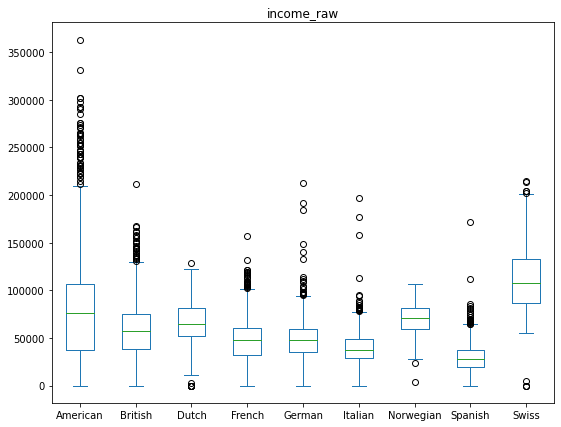

In [9]:
people_df[['nationality','income_raw']].plot.box(by='nationality', figsize=(9,7))

income_raw    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

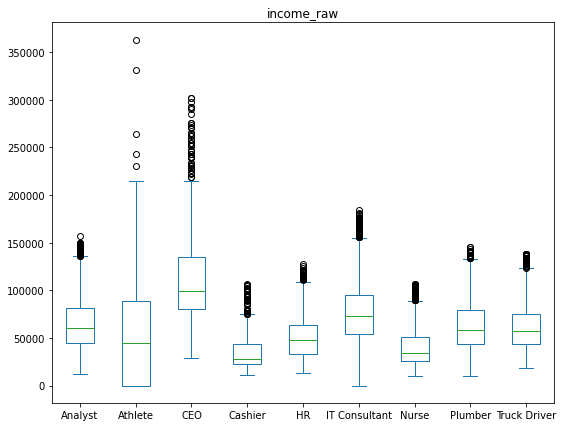

In [10]:
people_df[['job','income_raw']].plot.box(by='job', figsize=(9,7))

In [11]:
# pd.pivot_table(people_df.reset_index(), columns=['job','nationality'], values='income_raw').plot.box(subplots=True, layout=(9,9), figsize=(15,7),)

,income_raw
nationality,
American,"AxesSubplot(0.125,0.125;0.775x0.755)"
British,"AxesSubplot(0.125,0.125;0.775x0.755)"
Dutch,"AxesSubplot(0.125,0.125;0.775x0.755)"
French,"AxesSubplot(0.125,0.125;0.775x0.755)"
German,"AxesSubplot(0.125,0.125;0.775x0.755)"
Italian,"AxesSubplot(0.125,0.125;0.775x0.755)"
Norwegian,"AxesSubplot(0.125,0.125;0.775x0.755)"
Spanish,"AxesSubplot(0.125,0.125;0.775x0.755)"
Swiss,"AxesSubplot(0.125,0.125;0.775x0.755)"


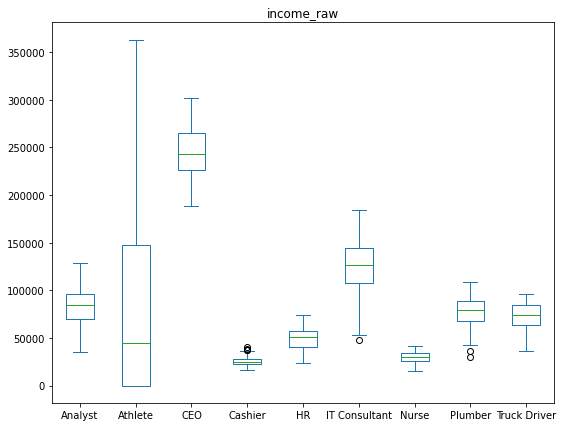

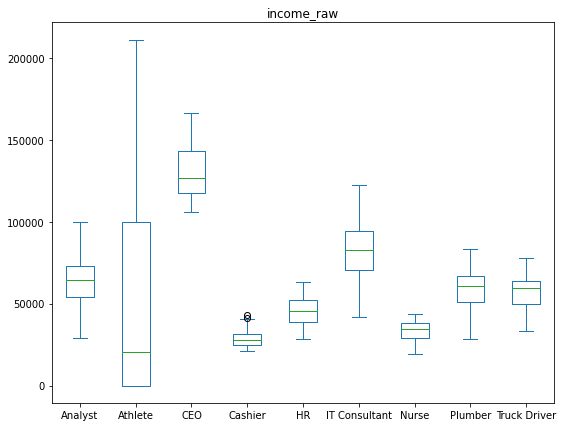

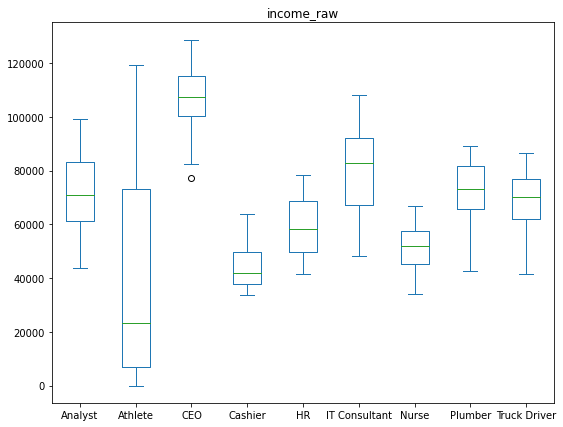

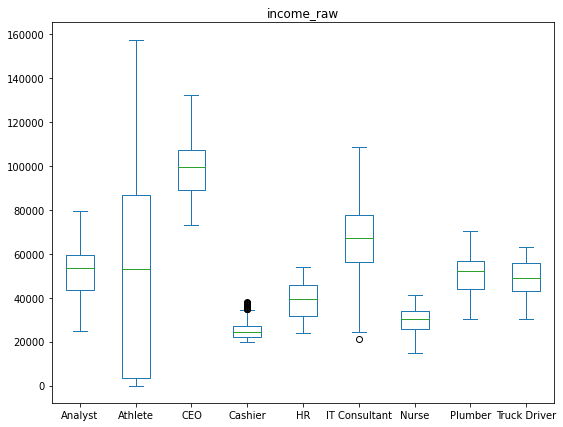

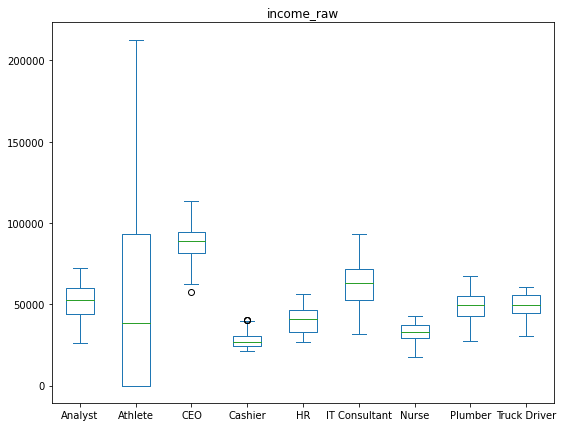

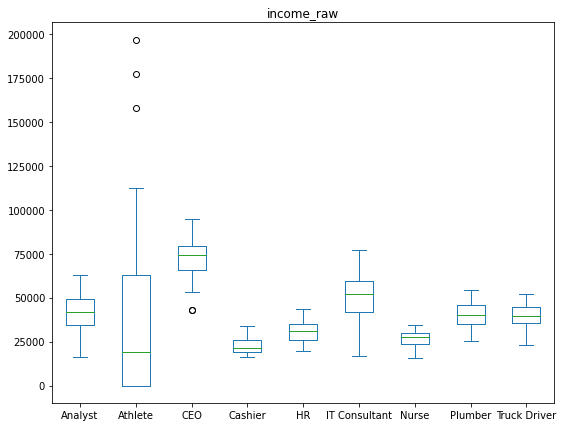

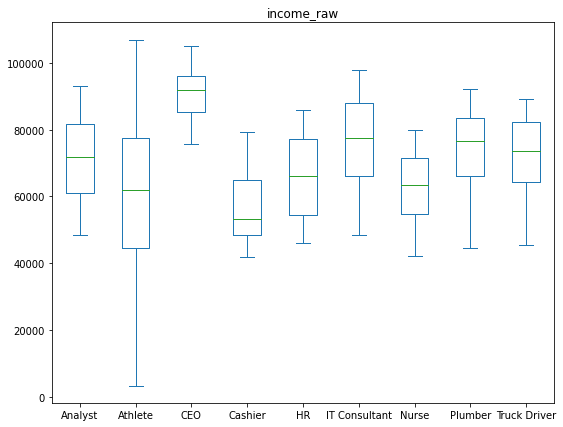

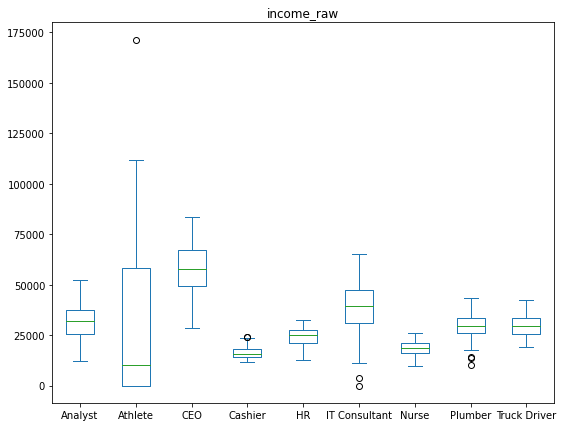

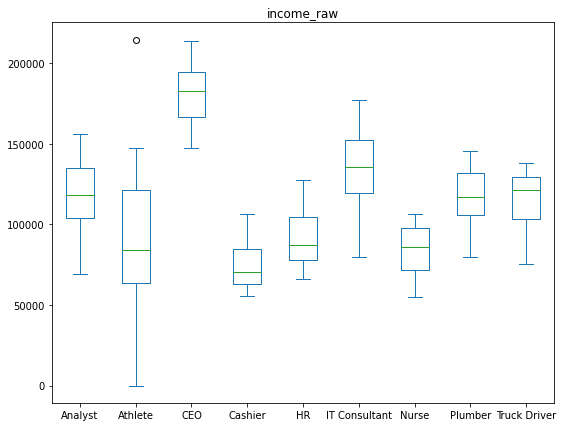

In [13]:
grpd = people_df.groupby('nationality')[['nationality','job','income_raw']]
grpd.plot.box(by='job', figsize=(9,7), subplots=True)

income_raw    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

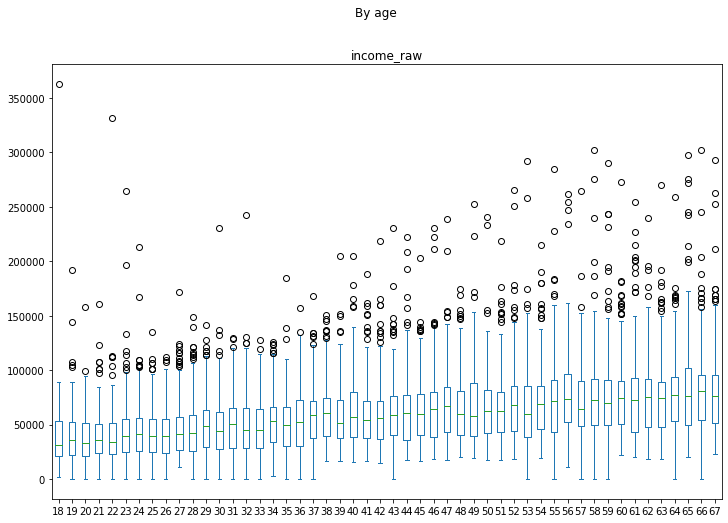

In [17]:
people_df[['age','income_raw']].plot.box(by='age', figsize=(12,8), title='By age')